In [40]:
# Imports
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
import localthickness as lt
import time
import pandas as pd

# change directory to the project directory
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

In [41]:
def get_thickness(bin_sample, mask_sample, pixel_size):
    """
    Calculates the local thickness of a binary sample.

    Args:
        bin_sample: A 3D numpy array representing the binary sample.
        mask_sample: A 3D numpy array representing the mask of the sample.
        pixel_size: The physical size of each pixel.

    Returns:
        A 3D numpy array representing the local thickness of the sample.
    """

    # get the local thickness radius
    local_thickness = lt.local_thickness(bin_sample, mask=mask_sample)
    # get the diameter
    thickness_true = 2*local_thickness
    # convert to physical size
    thickness_true *= pixel_size

    return thickness_true

def get_statistics(bin_sample, mask_sample, pixel_size):
    """
    Calculates the statistics of a binary sample.

    Args:
        bin_sample: A 3D numpy array representing the binary sample.
        mask_sample: A 3D numpy array representing the mask of the sample.
        pixel_size: The physical size of each pixel.

    Returns:
        A dict containing the statistics of the sample.
    """

    # get the stone/total ratio
    ratio = np.sum(bin_sample)/np.sum(mask_sample)

    # get the stone local thickness and time it
    start_time_stone = time.time()
    thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
    end_time_stone = time.time()

    # get the bubbles local thickness and time it   
    start_time_bubbles = time.time()
    thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)
    end_time_bubbles = time.time()

    # get the time it took to calculate the thickness
    time_stone = end_time_stone - start_time_stone
    time_bubbles = end_time_bubbles - start_time_bubbles

    # get the mean thickness
    mean_thickness_stone = np.mean(thickness_stone[thickness_stone > 0])
    mean_thickness_bubbles = np.mean(thickness_bubbles[thickness_bubbles > 0])

    # get the median thickness
    median_thickness_stone = np.median(thickness_stone[thickness_stone > 0])
    median_thickness_bubbles = np.median(thickness_bubbles[thickness_bubbles > 0])

    # get the max thickness
    max_thickness_stone = np.max(thickness_stone)
    max_thickness_bubbles = np.max(thickness_bubbles)

    # get the thickness variance
    var_thickness_stone = np.var(thickness_stone[thickness_stone > 0])
    var_thickness_bubbles = np.var(thickness_bubbles[thickness_bubbles > 0])

    # create a dictionary with the results
    dict = {'ratio': ratio, 'mean_thickness_stone': mean_thickness_stone, 'mean_thickness_bubbles': mean_thickness_bubbles, 'median_thickness_stone': median_thickness_stone, 'median_thickness_bubbles': median_thickness_bubbles, 'max_thickness_stone': max_thickness_stone, 'max_thickness_bubbles': max_thickness_bubbles, 'var_thickness_stone': var_thickness_stone, 'var_thickness_bubbles': var_thickness_bubbles, 'time_stone': time_stone, 'time_bubbles': time_bubbles}

    return dict


def extract_samples(mask, pixels_per_mm, mm_per_grid=5, discard_threshold=0.5):
    """
    Extracts a grid of samples from a mask where each sample has a meaningful amount of data.

    Args:
        mask: A 3D numpy array representing the mask.
        pxels_per_mm: The number of pixels per mm in the volume.
        mm_per_grid: The physical size of each grid element.
        discard_threshold: The threshold for discarding samples based on the mask.

    Returns:
        A list of dicts that map the indices of the extracted samples
    """
    samples = []
    for i in range(0, mask.shape[0], int(mm_per_grid * pixels_per_mm)):
        for j in range(0, mask.shape[1], int(mm_per_grid * pixels_per_mm)):
            for k in range(0, mask.shape[2], int(mm_per_grid * pixels_per_mm)):
                if np.mean(mask[i:i + int(mm_per_grid * pixels_per_mm), j:j + int(mm_per_grid * pixels_per_mm), k:k + int(mm_per_grid * pixels_per_mm)]) > discard_threshold:
                    samples.append({'i': (i, i + int(mm_per_grid * pixels_per_mm)),
                                    'j': (j, j + int(mm_per_grid * pixels_per_mm)),
                                    'k': (k, k + int(mm_per_grid * pixels_per_mm))})
    return samples

def apply_grid(volume, grid_dict):
    """
    Extracts a sliced volume based on the grid_dict.
    
    volume: A 3D numpy array representing the volume.
    grid_dict: A dict containing the indices of the volume to extract as given in extract_samples
    
    """
    i, i_mark = grid_dict['i']
    j, j_mark = grid_dict['j']
    k, k_mark = grid_dict['k']

    return volume[i:i_mark, j:j_mark, k:k_mark]
    

In [42]:
# load the full data, bin_data and mask for the three stones (for the the Island ny stone we also load the downsampled data)

folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01'

stone = 'island_gammel'
file_name = 'lavasten_Island_gammel_LFOV-80kV-LE5-4s-45.3micro_recon.txm'
absolute_path = os.path.join(folder_path, stone, file_name)
all_data = dxchange.reader.read_txm(absolute_path)

file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
bin_data = tifffile.imread(absolute_path)

file_name = 'mask.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
mask = tifffile.imread(absolute_path)


In [43]:
print(all_data[1].keys())
data = all_data[0]
pixel_size = all_data[1]['pixel_size']
print(pixel_size)
img_shape = data.shape
print(img_shape)
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print(total_size__mm)
pixel_size_mm = pixel_size/1000
pixels_per_mm = 1/pixel_size_mm
print(pixels_per_mm)

dict_keys(['facility', 'image_width', 'image_height', 'data_type', 'number_of_images', 'pixel_size', 'reference_filename', 'reference_data_type', 'thetas', 'x_positions', 'y_positions', 'z_positions', 'x-shifts', 'y-shifts', 'reference'])
45.34814453125
(1017, 1024, 1004)
[46.11906299 46.4365     45.52953711]
22.051618877391707


In [44]:
# visualize the data
crop_size = int(4*pixels_per_mm)
start_x = 450#440
end_x = start_x + crop_size
start_y = 470#420
end_y = start_y + crop_size
start_z = 280#280
end_z = start_z + crop_size
slice = 100# crop_size
slice_x = start_x + slice
slice_y = start_y + slice
slice_z = start_z + slice

In [45]:
sample = data[start_z:end_z, start_x:end_x, start_y:end_y]
bin_sample = bin_data[start_z:end_z, start_x:end_x, start_y:end_y]
mask_sample = mask[start_z:end_z, start_x:end_x, start_y:end_y]

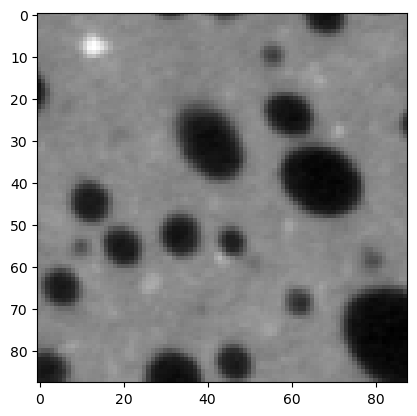

<Figure size 640x480 with 0 Axes>

In [46]:
# visualize the sample
slice = crop_size//2
plt.figure()
plt.imshow(sample[slice, :, :], cmap='gray')
plt.show()
# save the sample
path = os.path.join('results', 'sample_slice.png')
plt.savefig(path)



In [47]:
thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)

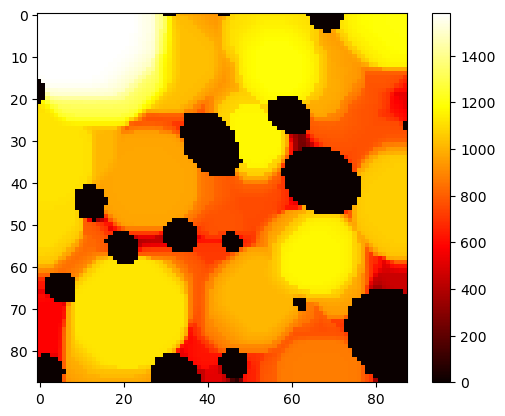

<Figure size 640x480 with 0 Axes>

In [48]:
# visualize the thickness_stone
plt.figure()
plt.imshow(thickness_stone[slice, :, :], cmap='hot')
plt.colorbar()
plt.show()
# save the thickness_stone
path = os.path.join('results', 'local_thickness_stone.png')
plt.savefig(path)

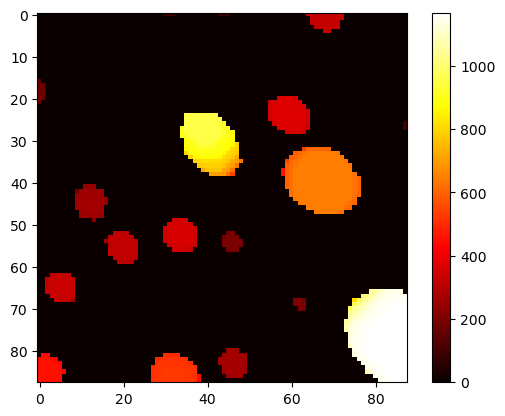

<Figure size 640x480 with 0 Axes>

In [49]:
# visualize the thickness_stone
slice = crop_size//2
plt.figure()
plt.imshow(thickness_bubbles[slice, :, :], cmap='hot')
plt.colorbar()
plt.show()
# save the thickness_stone
path = os.path.join('results', 'local_thickness_air.png')
plt.savefig(path)